## Model labels error

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai import * 
from fastai.vision import *

from pathlib import Path
import json 
from matplotlib import patches, patheffects
import os 
import collections
import pandas as pd

In [4]:
imgs = [] 
img_file = open('data/boxes.csv', 'r')
for line in img_file: 
    en = line.strip().split(',') 
    imgs.append( (en[0], [int(i) for i in en[1].split()] , en[2]))

In [5]:
images = [ str(i[0]) for i in imgs ]
lbl_bbox = [ [ [  [i[1][1], i[1][0],i[1][3],i[1][2]  ] ] , [i[2]] ] for i in imgs]
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [7]:
data = (ObjectItemList.from_folder('data/imgs')
        .split_none()                          
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .transform(None, size=224, tfm_y=True, resize_method=ResizeMethod.SQUISH)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=3, collate_fn=bb_pad_collate, num_workers=0))   
        #Finally we convert to a DataBunch and we use bb_pad_collate

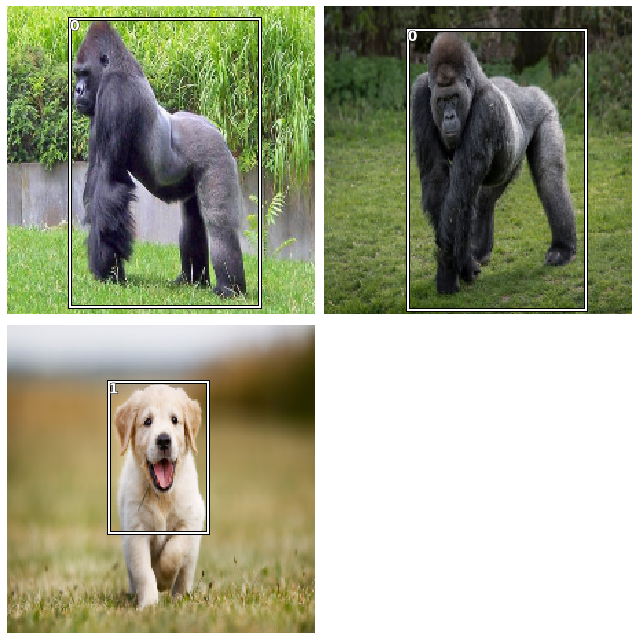

In [8]:
data.show_batch(2, figsize=(9,9))

In [9]:
f_model = models.resnet34
sz=224

labels = set([ i[2] for i in imgs ])
n_classes = len(labels)

In [21]:
def detn_loss(input, target1, target2):
    h,w = target2.shape
    target2 = target2.reshape(h)
    bb_t, c_t = target1, target2
    print("Target classes %s" % c_t)
    bb_i, c_i = input[:,:4], input[:, 4:]
    bb_i = F.torch.sigmoid(bb_i) * 224
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t) * 20

In [20]:
head_reg = nn.Sequential(
    Flatten(),
    nn.Linear(25088, 4 + n_classes)
)
learn = cnn_learner(data, f_model, custom_head=head_reg)
learn.opt_fn = optim.Adam
learn.loss_func = detn_loss
learn.lr_find()

Target classes tensor([1, 2, 1])


/usr/local/Cellar/python3/3.6.4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Using a target size (torch.Size([3, 1, 4])) that is different to the input size (torch.Size([3, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  if __name__ == '__main__':


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at ../aten/src/THNN/generic/ClassNLLCriterion.c:92